# 06.01 Optimize 1:  Logistic Regression Model
 
Goal: identify the factors that most contribute to SLAFail

Tuning Adjustments: Focus on finding the most predictive set of predictor variables

Read Prepared Data  ->  Split Data  -> Develop Pipeline  ->  Evaluate  

Split Data using sklearn.model_selection.train_test_split

Pipeline includes:

- Preprocessing variables
    - sklearn.compose.make_column_transformer 
    - Scale numeric variables: sklearn.preprocessing.StandardScaler
    - Encode categorical variables: category_encoders.MEstimateEncoder
- Selecting features
    - sklearn.feature_selection.SelectKBest
    - sklearn.feature_selection.f_classif
- Instantiate model
    - sklearn.linear_model.LogisticRegression
- Fit the model using training data
- Cross-validate the model with training data
    - sklearn.model_selection.cross_val_score
- Output performance measures

Evaluate involves running the pipeline with the testing data and capturing metrics


https://github.com/justmarkham/scikit-learn-videos/blob/master/08_grid_search.ipynb




In [16]:

# Load libraries
import pandas as pd
import numpy as np
import pickle
pd.set_option('precision', 9)


# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.compose import make_column_transformer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn import metrics

In [2]:
# create dictionary to store information about the pipeline and results for later reporting and review
PipeLineMetadata = { "Name" : "Optimize Round 1 (only SelectKBest with f_classif" }

In [3]:
outFileName = "data/06.00.a Optimize with SelectKBest.pkl"

In [4]:
df = pd.read_csv("data/05.00 Incident Data.csv")
print("df.shape: " + str(df.shape))
print("df.columns: " + str(df.columns))
print("df.dtypes: \n" + str(df.dtypes))

df.shape: (35208, 10)
df.columns: Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
       'Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes', 'SLAFail', 'Open_Time_HourOfDay',
       'Open_Time_DayOfWeek', 'CI_TypeSubType_aff'],
      dtype='object')
df.dtypes: 
Service_Component_WBS_aff      object
Urgency                        object
KM_number                      object
Count_Related_Interactions    float64
Count_Related_Incidents       float64
Count_Related_Changes         float64
SLAFail                         int64
Open_Time_HourOfDay             int64
Open_Time_DayOfWeek            object
CI_TypeSubType_aff             object
dtype: object


## Read Prepared Data

#### Set X and y

In [5]:
y = df.SLAFail
y.shape

(35208,)

In [6]:
X = df.drop(['SLAFail'], axis='columns')
X.shape

(35208, 9)

Set `Open_Time_HourOfDay` for recognition as a Categorical variable

In [7]:
X.Open_Time_HourOfDay = X.Open_Time_HourOfDay.astype('object')
X.dtypes

Service_Component_WBS_aff      object
Urgency                        object
KM_number                      object
Count_Related_Interactions    float64
Count_Related_Incidents       float64
Count_Related_Changes         float64
Open_Time_HourOfDay            object
Open_Time_DayOfWeek            object
CI_TypeSubType_aff             object
dtype: object

Create a list of numeric variable column names

In [8]:
numericVars = X.select_dtypes(include=['float64']).columns
numericVars

Index(['Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes'],
      dtype='object')

Create a list of categorical variables

In [9]:
categoricalVars = X.select_dtypes(include=['object']).columns
categoricalVars

Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
       'Open_Time_HourOfDay', 'Open_Time_DayOfWeek', 'CI_TypeSubType_aff'],
      dtype='object')

## Split Data

Create Training and Testing Data Sets


In [10]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)


In [11]:
print(X_train.shape)
print(X_train.columns)

(24645, 9)
Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
       'Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes', 'Open_Time_HourOfDay', 'Open_Time_DayOfWeek',
       'CI_TypeSubType_aff'],
      dtype='object')


## Calculate Null Accuracy

Null accuracy: accuracy that could be achieved by always predicting the most frequent class

This means that a dumb model that always predicts 0 would be right 68% of the time

This shows how classification accuracy is not that good as it's close to a dumb model
It's a good way to know the minimum we should achieve with our models


In [12]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()


0    7445
1    3118
Name: SLAFail, dtype: int64

In [13]:
# calculate the percentage of ones
print("Percentage of Ones: %f " % y_test.mean())
print("Percentage of Zeros: %f " % (1 - y_test.mean()))
print("Percentage of Zeros: %f " % ( 1 - y_test.mean() ) )
null_accuracy = max(y_test.mean(), 1 - y_test.mean())
PipeLineMetadata = { "Null Accuracy" : null_accuracy }
print("Null Accuracy: %f " % null_accuracy )


Percentage of Ones: 0.295181 
Percentage of Zeros: 0.704819 
Percentage of Zeros: 0.704819 
Null Accuracy: 0.704819 


This means that a 'dumb' model that always predicts 0 would be right 70% of the time. 

The developed model must exceed a 70% accuracy rate to be considered better than the 'dumb' model.

## Develop Pipeline


### Encode Variables

Numeric and categorical variables require different treatment 

Set up column transformer for scaling numeric variables and encoding categorical variables



In [14]:
column_trans = make_column_transformer(
    (ce.WOEEncoder(), categoricalVars),
    (StandardScaler(), numericVars),
    remainder='passthrough')

### Feature Selection




In [17]:
selector = SelectKBest(score_func=f_classif)

### Specify Classifier (Logistic Regression)

In [18]:
classifier = LogisticRegression(solver="lbfgs")

### Compose Pipeline

In [19]:
pipe = Pipeline(steps=[('column_trans', column_trans), 
                        ('selector',  selector),
                        ('classifier', classifier)
                        ])

### Set Parameters for Grid Search Cross Validation

In [20]:
selectKBestRange = list(range(1, len(X_train.columns)+1 ))
selectKBestRange

[1, 2, 3, 4, 5, 6, 7, 8, 9]

### Create parameter grid


In [21]:
param_grid = dict(selector__k=selectKBestRange)
param_grid

{'selector__k': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

### Instantiate the search


In [22]:
search = GridSearchCV(pipe, param_grid, n_jobs=1)

In [23]:
search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('column_trans',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('woeencoder',
                                                                         WOEEncoder(cols=None,
                                                                                    drop_invariant=False,
                                                                                    handle_missing='value',
                                                                                    handle_unknown='value',
                                      

In [24]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.738):
{'selector__k': 9}


In [25]:
search.estimator.named_steps.selector

SelectKBest(k=10, score_func=<function f_classif at 0x1a210f35f0>)

Get predicted classification and predicted probabilities based on the model

In [26]:
y_pred_class = search.predict(X_test)


In [27]:
y_pred_prob = search.predict_proba(X_test)[:,1]



In [28]:
print(metrics.classification_report(y_test, y_pred_class))

precision    recall  f1-score   support

           0       0.78      0.89      0.83      7445
           1       0.60      0.41      0.49      3118

    accuracy                           0.75     10563
   macro avg       0.69      0.65      0.66     10563
weighted avg       0.73      0.75      0.73     10563



Look at the resulting confusion matrix

Save True Positive (TP), True Negative (TN), False Positive(FP), and False Negative (FN) values

In [29]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)
print("TN: %d \t FP: %d \nFN: %d \t TP: %d " % (TN, FP, FN, TP))

[[6597  848]
 [1826 1292]]
TN: 6597 	 FP: 848 
FN: 1826 	 TP: 1292 


Add some ROC curve information and AUC result


In [30]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
metrics.roc_auc_score(y_test, y_pred_prob)

0.7806294265709925

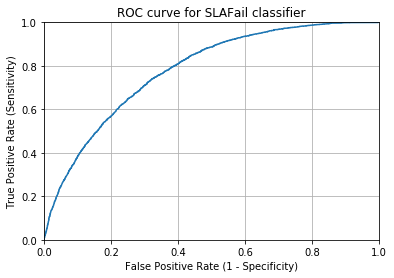

In [31]:
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for SLAFail classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Capture resulting AUC

## Save Details and Performance Measures for Comparison to other Models


Capture a few classification metrics:
* Classification Accuracy: Overall, how often is the classifier correct?
* Classification Error: Overall, how often is the classifier incorrect?
* True Positive Rate  (Recall, Sensitivity): When the actual value is positive, how often is the prediction correct?
* True Negative Rate (Specificity): When the actual value is negative, how often is the prediction correct?
* False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
* Precision: When a positive value is predicted, how often is the prediction correct?


In [32]:
PipeLineMetadata['Metrics - Classification Report'] = metrics.classification_report(y_test, y_pred_class)
PipeLineMetadata['Metrics - Confusion Matrix'] =metrics.confusion_matrix(y_test, y_pred_class)
PipeLineMetadata['Metrics - Confusion Matrix Classification Accuracy'] = metrics.accuracy_score(y_test,y_pred_class) 
PipeLineMetadata['Metrics - Confusion Matrix Classification Error'] = 1- metrics.accuracy_score(y_test,y_pred_class)
PipeLineMetadata['Metrics - Confusion Matrix True Positive Rate'] = metrics.recall_score(y_test, y_pred_class) 
PipeLineMetadata['Metrics - Confusion Matrix True Negative Rate'] =  TN / float(TN + FP)
PipeLineMetadata['Metrics - Confusion Matrix False Positive Rate'] =  FP / float(TN + FP)
PipeLineMetadata['Metrics - Confusion Matrix Precision'] = metrics.precision_score(y_test,y_pred_class)


In [33]:
PipeLineMetadata['Metrics - AUC'] = metrics.roc_auc_score(y_test, y_pred_prob)

In [34]:
PipeLineMetadata['Metrics - ROC Curve fpr array'] = fpr
PipeLineMetadata['Metrics - ROC Curve tpr array'] = tpr

In [35]:
PipeLineMetadata

{'Null Accuracy': 0.7048187068067784,
 'Metrics - Classification Report': '              precision    recall  f1-score   support\n\n           0       0.78      0.89      0.83      7445\n           1       0.60      0.41      0.49      3118\n\n    accuracy                           0.75     10563\n   macro avg       0.69      0.65      0.66     10563\nweighted avg       0.73      0.75      0.73     10563\n',
 'Metrics - Confusion Matrix': array([[6597,  848],
        [1826, 1292]]),
 'Metrics - Confusion Matrix Classification Accuracy': 0.7468522200132538,
 'Metrics - Confusion Matrix Classification Error': 0.2531477799867462,
 'Metrics - Confusion Matrix True Positive Rate': 0.4143681847338037,
 'Metrics - Confusion Matrix True Negative Rate': 0.8860980523841504,
 'Metrics - Confusion Matrix False Positive Rate': 0.11390194761584957,
 'Metrics - Confusion Matrix Precision': 0.6037383177570094,
 'Metrics - AUC': 0.7806294265709925,
 'Metrics - ROC Curve fpr array': array([0.        , 0

In [36]:
with open(outFileName,'wb') as fo:
    pickle.dump(PipeLineMetadata, fo)

In [37]:
# with open("FILENAME", 'rb') as fi:
#    BareBonesMetadata = pickle.load(fi)